In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import utils as ut

In [2]:
ds_mld = xr.open_dataset('Data/cesm_mld.nc')

In [3]:
mld_climo = ds_mld.groupby('time.month').mean('time')['mld']
lon = ds_mld['lon']
lat = ds_mld['lat']

### Plotting the monthly and Seasonal MLD values

What the two maps below show is that over the spring season (March-April-May), the MLD is at its deepest level, meaning that this period would be the best to use for examining the MLD-AMOC relationship.

Text(0.5, 0.98, 'Mixed Layer Depth')

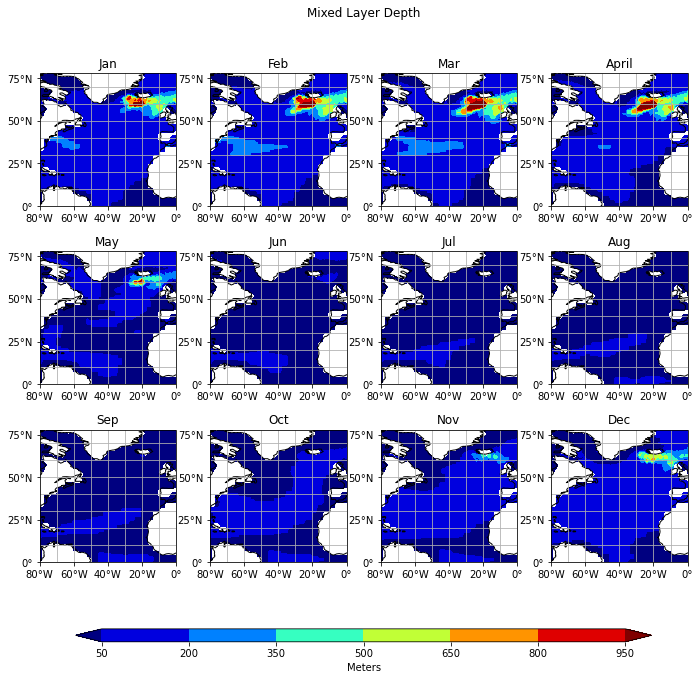

In [4]:
fig,ax = plt.subplots(nrows=3,ncols=4,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(10,9))
ax = ax.flatten()

clevs = np.arange(50,951,150)
months = ['Jan','Feb','Mar','April','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i, mon in enumerate(months):
    ax[i].set_extent([-80,0,0,75])
    cs = ax[i].contourf(lon,lat,mld_climo[i]/100,cmap='jet',transform=ccrs.PlateCarree(),extend='both',levels=clevs)
    
    #Longitude Labels
    ax[i].set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    
    #Latitude Labels
    ax[i].set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[i].yaxis.set_major_formatter(lat_formatter)

    
    ax[i].coastlines()
    ax[i].gridlines()
    ax[i].set_title(mon)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.1,top=0.9,left=0.05,right=0.95,wspace=0.25,hspace=0.1)
cbar_ax = fig.add_axes([0.1,0,0.8,0.02])
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Meters')
plt.suptitle('Mixed Layer Depth')
#fig.tight_layout()


### Plotting the seasonal MLD values

Text(0.5, 0.98, 'Seasonal Mixed Layer Depth')

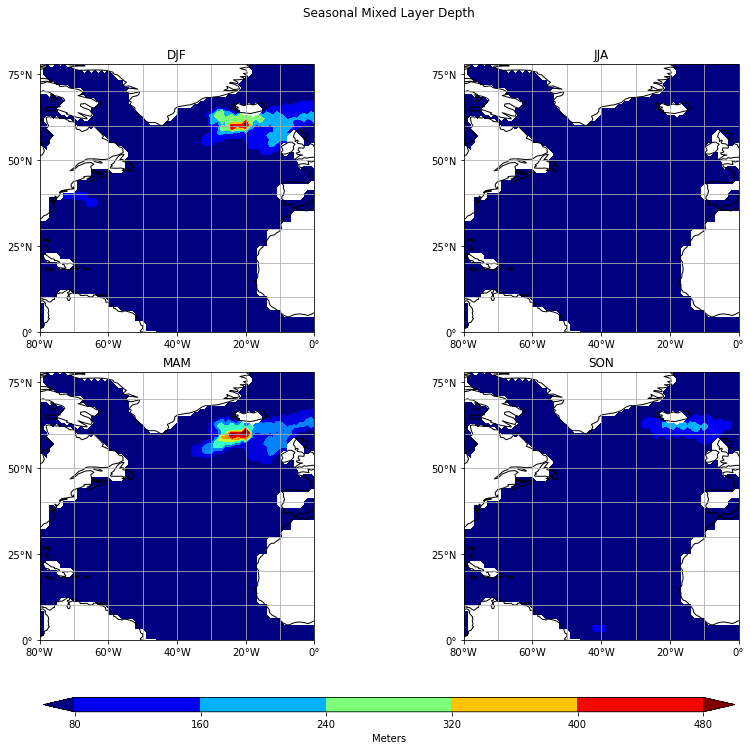

In [5]:
ds_seasonal = ds_mld.groupby('time.season').mean('time')

fig, ax = plt.subplots(nrows=2,ncols=2, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,10))

ax = ax.flatten()

for i, seas in enumerate(ds_seasonal['season']):
    cs = ax[i].contourf(ds_seasonal['lon'],ds_seasonal['lat'],ds_seasonal['mld'].sel(season=seas)/100
                        ,cmap='jet',transform=ccrs.PlateCarree(),extend='both')
    ax[i].set_extent([-80,0,0,75])
    #Longitude Labels
    ax[i].set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    
    #Latitude Labels
    ax[i].set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[i].yaxis.set_major_formatter(lat_formatter)

    
    ax[i].coastlines()
    ax[i].gridlines()
    ax[i].set_title(seas.values)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.1,top=0.9,left=0.05,right=0.95,wspace=0.2,hspace=0.15)
cbar_ax = fig.add_axes([0.1,0,0.8,0.02])
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Meters')
plt.suptitle('Seasonal Mixed Layer Depth')
#plt.tight_layout()

### Getting the AMOC index and its annual mean values

In [6]:
ds_amoc = xr.open_dataset('Data/cesm_maxAMOC.nc')
ds_amoc = ds_amoc.groupby('time.year').mean('time')

### Using the function utils.selectSeason to get the winter (DJF) mixed-layer depth

In [7]:
ds_mld_seas = ut.selectSeason(ds_mld,'MAM')

Now, we need to find the mean and standard deviation of the AMOC for plotting and for testing it against the MLD

In [8]:
amoc = ds_amoc['maxAMOC']

mu_amoc = amoc.mean('year')
sd_amoc = amoc.std('year')
mu_amoc
print('Mean AMOC strength:', np.round(mu_amoc.values,2), 'Sverdrups')
print('Standard Deviation of the AMOC:',np.round(sd_amoc.values,2), 'Sverdrups')

Mean AMOC strength: 14.76 Sverdrups
Standard Deviation of the AMOC: 0.75 Sverdrups


### Plotting the AMOC at 30N
This merely shows the index of the AMOC being used going forward. To begin, the composites of the MLD will be taken by separating Spring values based on whether the AMOC is above or below the average strength of 14.76 Sv  (10^6 m^3/s). Visually, this can be interpreted as years where the time series is above and below the red line denoting the average transport.

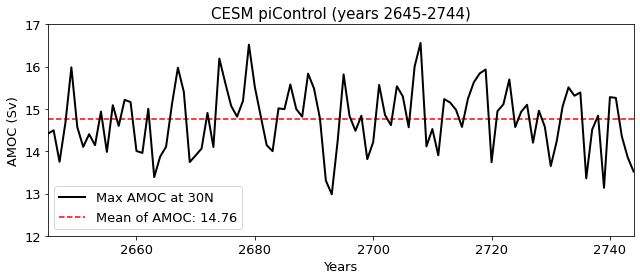

In [9]:
yrs = np.arange(2645,2745)
fig = plt.figure(figsize=(9,4))
fs = 13
ax = plt.axes()
ax.plot(yrs,amoc,'k', linewidth=2.)
ax.tick_params(labelsize=fs)
ax.hlines(mu_amoc,min(yrs),max(yrs),'r',linestyles='--')
ax.legend(['Max AMOC at 30N', 'Mean AMOC: '+str(np.round(mu_amoc.values,2))]+' Sv',fontsize=fs)


plt.xlabel('Years',fontsize=fs)
plt.ylabel('AMOC (Sv)',fontsize=fs)

plt.axis([min(yrs),max(yrs),12,17])
plt.title('CESM piControl (years 2645-2744)',fontsize=15)
plt.tight_layout()

### Getting the MLD for periods where the AMOC is both above and below one standard deviation of the mean

In [10]:
highAMOC = ds_amoc.where(amoc>mu_amoc)#(mu_amoc+sd_amoc))
lowAMOC = ds_amoc.where(amoc<mu_amoc)#(mu_amoc-sd_amoc))

counts = [highAMOC.count(dim='year').values,  lowAMOC.count(dim='year').values]
mldHigh = ds_mld_seas.sel(year=highAMOC.dropna(dim='year')['year']).mean(dim='year')
mldLow = ds_mld_seas.sel(year=lowAMOC.dropna(dim='year')['year']).mean(dim='year')


### Plotting the MLD for above and below average MLD's

The fact that the MLD during periods of a strong AMOC are associated with a greater MLD suggests a relationship. Below these composites, selections at 55˚N-25˚W (within the Iceland Basin) and 24˚N-40˚W (outside the Iceland Basin) show that the Iceland Basin, where the MLD is typically at its greatest, has some linear relationship with the strength of the AMOC.

Text(0.5, 0.98, 'Changes in Mixed Layer Depth')

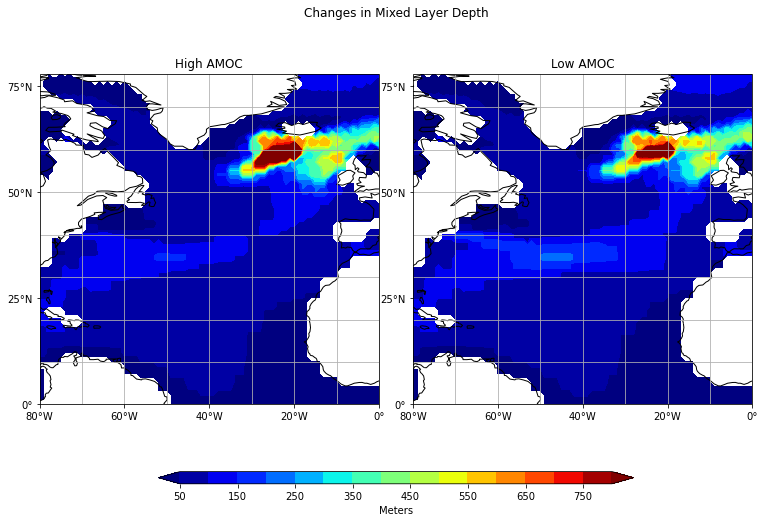

In [18]:
MLDtypes = [mldHigh['mld']/100,mldLow['mld']/100]

fig,ax = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(11.,8.5))
ax = ax.flatten()

clevs = np.arange(50,801,50)
titles = ['High AMOC', 'Low AMOC']#, 'Difference in AMV\'s']
for i, t in enumerate(titles):
    ax[i].set_extent([-80,0,0,75])
    cs = ax[i].contourf(lon,lat,MLDtypes[i],cmap='jet',transform=ccrs.PlateCarree(),extend='both',levels=clevs)
    
    #Longitude Labels
    ax[i].set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    
    #Latitude Labels
    ax[i].set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[i].yaxis.set_major_formatter(lat_formatter)

    
    ax[i].coastlines()
    ax[i].gridlines()
    ax[i].set_title(t)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.3,top=0.9,left=0.05,right=0.95,wspace=0.1,hspace=0.4)
cbar_ax = fig.add_axes([0.2,0.2,0.6,0.02])
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Meters')
plt.suptitle('Changes in Mixed Layer Depth')

### Adding a plot of the difference between MLD's when the AMOC is above and below the mean (high-low)

Text(0.5, 1.0, 'High AMOC - Low AMOC')

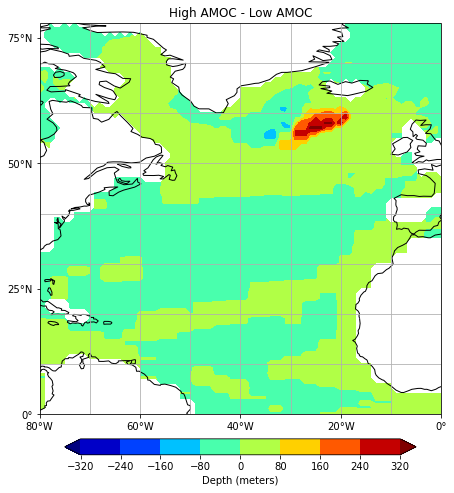

In [12]:
mldDiff = mldHigh['mld']/100 - mldLow['mld']/100

clevs = np.arange(-320,321,80)

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80,0,0,75])

cs = ax.contourf(lon,lat,mldDiff,cmap='jet',levels=clevs,extend='both', transform=ccrs.PlateCarree())
#adding coastlines
ax.coastlines()
#Add Gridlines
ax.gridlines()

#Defining the x-ticks for longitude
ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

#Now getting the y-ticks
ax.set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Calling the colorbar
cbar = plt.colorbar(cs,orientation='horizontal',shrink=0.7, pad = 0.05, label='Depth (meters)')
plt.title('High AMOC - Low AMOC')

### Looking at the MLD vs AMOC relationship at 55˚N and 25˚W (high composite), and 25˚N and 40˚W (low)

In [ ]:
mld_slice_high = ds_mld_seas.sel(lon=360-25,lat=55,method='nearest')['mld']
mld_slice_low = ds_mld_seas.sel(lon=360-40,lat=25,method='nearest')['mld']

labels = ['55N, 25W','25N, 40W']

mld_slice = [mld_slice_high,mld_slice_low]
plt.figure(figsize=(11,5))


for i in range(2):
    plt.subplot(1,2,i+1)
    plt.scatter(mld_slice[i]/100,amoc,color='b')

    plt.ylabel('AMOC (Sv)')
    plt.xlabel('MLD (M)')
    plt.axhline(mu_amoc,color='k')
    plt.title(labels[i])

plt.tight_layout()

### Regressing the MLD onto the AMOC

In [14]:
nx = len(ds_mld_seas['lat'])
ny = len(ds_mld_seas['lon'])

p_array = np.zeros((nx,ny))
r_array = np.zeros((nx,ny))
m_array = np.copy(p_array)

for i in range(nx):
    for j in range(ny):
        x = amoc
        y = ds_mld_seas['mld'][:,i,j]/100
        
        m,b,r,p,e = sps.linregress(x,y)
        
        m_array[i,j]=m
        r_array[i,j]=r
        p_array[i,j]=p

In [15]:
mask_sig = np.where(p_array<0.05,m_array,np.nan)

### Plotting the regression map of MLD onto the AMOC

Text(0.5, 1.0, 'CESM Preindustrial Control')

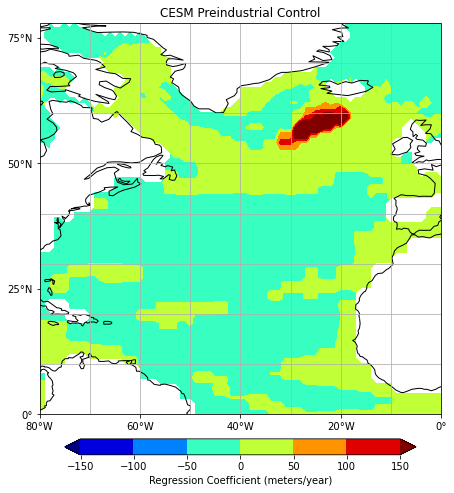

In [16]:
clevs = np.arange(-150,151,50)
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80,0,0,75])

cs = ax.contourf(lon,lat,m_array,cmap='jet',extend='both',levels=clevs, transform=ccrs.PlateCarree())

#adding coastlines
ax.coastlines()
#Add Gridlines
ax.gridlines()

#Defining the x-ticks for longitude
ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

#Now getting the y-ticks
ax.set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Calling the colorbar
cbar = plt.colorbar(cs,orientation='horizontal',shrink=0.7, pad = 0.05, label='Regression Coefficient (meters/year)')
plt.title('CESM Preindustrial Control')

### Looking at the correlation between the AMOC and MLD in the Northern Atlantic
While the regression map, above, shows the linear relationship between the AMOC and the MLD in terms of regression coefficients, the map below illustrates the strength/validity of that relationship by region. For instance, the regression map shows a very strong linear relationship between the MLD in the Iceland Basin and the AMOC, the correlation map below illustrates that such a relationship isn't incredibly descriptive given that the correlations in that region don't exceed 0.4. However, the correlations are statistically significant, as indicated by the black dots on the map. This means that the MLD can function as a proxy for the strength of the AMOC, ableit not a particularly strong one.

Text(0.5, 1.0, 'CESM Preindustrial Control')

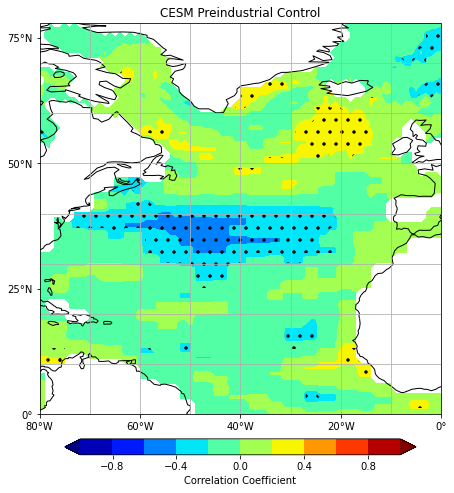

In [17]:
rMap = xr.corr(amoc,ds_mld_seas['mld']/100,dim='year')
clevs = np.arange(-1,1.1,0.2)
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80,0,0,75])

cs = ax.contourf(lon,lat,rMap,cmap='jet',extend='both',levels=clevs, transform=ccrs.PlateCarree())
ax.contourf(lon,lat,mask_sig,[0,1],colors='None',hatches=['.','.'],extend='both',levels=clevs, transform=ccrs.PlateCarree(),alpha=0)

#adding coastlines
ax.coastlines()
#Add Gridlines
ax.gridlines()

#Defining the x-ticks for longitude
ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

#Now getting the y-ticks
ax.set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Calling the colorbar
cbar = plt.colorbar(cs,orientation='horizontal',shrink=0.7, pad = 0.05, label='Correlation Coefficient')
plt.title('CESM Preindustrial Control')